In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
from shapely.geometry import Polygon, box


In [4]:
# TODO FILE NAME

In [2]:
ddir = 'G:\Alexis_data\Project\SpatialOmics_cellpose\results'
fullres_chanel_0 = "G:\Alexis_data\Project\SpatialOmics_cellpose\data\output-XETG00245__0034182__1835os__20240613__195055\morphology_focus\morphology_focus_0000.ome.tif"
fullres_chanel_2 = "G:\Alexis_data\Project\SpatialOmics_cellpose\data\output-XETG00245__0034182__1835os__20240613__195055\morphology_focus\morphology_focus_0002.ome.tif"

# Output directory
odir = f'{ddir}cellpose/'
gjurl = f'{odir}a.geojson'

# Levels: pixelsize in µm https://kb.10xgenomics.com/hc/en-us/articles/11636252598925
scalefactors = {
    0: 0.2125,
    1: 0.4250,
    2: 0.85,
    3: 1.7,
    4: 3.4,
    5: 6.8,
    6: 13.6,
    7: 27.2,
}


In [6]:
# Example usage
ROI_filepath = "G:/Alexis_data/Project/SpatialOmics_cellpose/data/output-XETG00245__0034182__1835os__20240613__195055/1835oS_corneasection.csv"

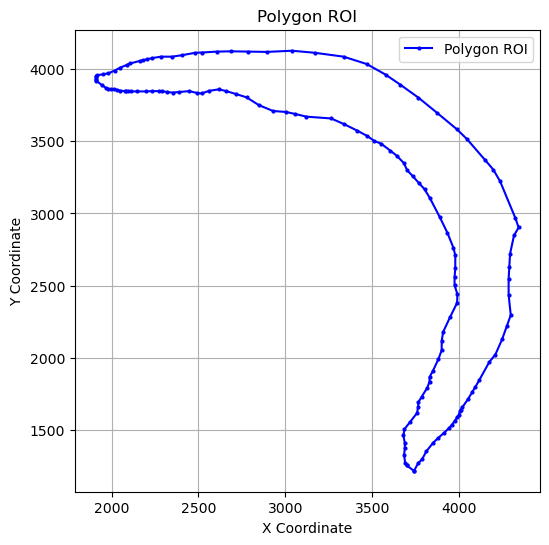

In [7]:
# Read the ROI coordinates from the CSV file
polygon_coords = pd.read_csv(ROI_filepath)

# Extract the X and Y coordinates
x_coords = polygon_coords['X']
y_coords = polygon_coords['Y']


# Create a plot
plt.figure(figsize=(6, 6))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b', label='Polygon ROI', markersize=2)

# Close the polygon by connecting the last point to the first
plt.plot([x_coords.iloc[0], x_coords.iloc[-1]], [y_coords.iloc[0], y_coords.iloc[-1]], 'b-')

# Adding labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title("Polygon ROI")
plt.legend()
plt.grid(True)

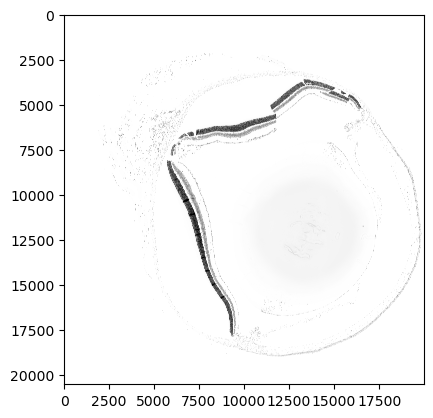

In [8]:
level = 0
pixelsize = scalefactors[level]
image_chanel_0 = tifffile.imread(fullres_chanel_0, is_ome=False, level=level)
plt.imshow(image_chanel_0, cmap='binary')
plt.axis('scaled')
plt.show()

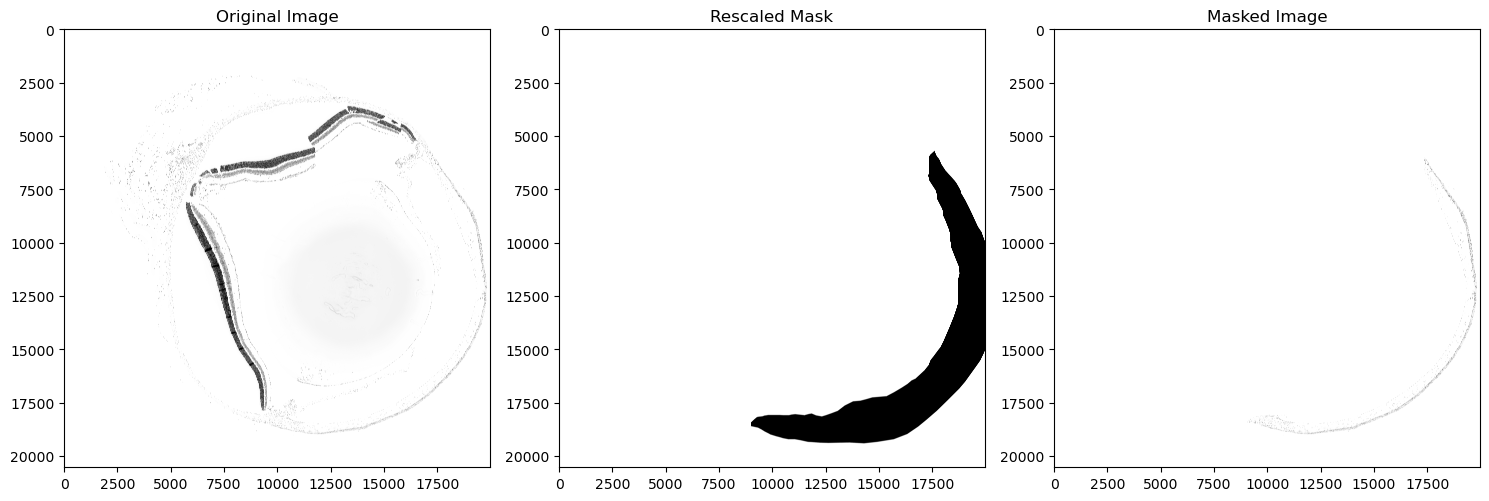

In [9]:
import cv2
import numpy as np

level = 0
pixelsize = scalefactors[level]

# 1. Rescale the coordinates
scaling_factor = pixelsize
x_coords_rescaled = x_coords / scaling_factor
y_coords_rescaled = y_coords / scaling_factor

# 2. Convert rescaled coordinates to points format for fillPoly
points_rescaled = np.column_stack((x_coords_rescaled, y_coords_rescaled)).astype(np.int32)
points_rescaled = points_rescaled.reshape((-1, 1, 2))

# 3. Create mask matching image shape
mask = np.zeros(image_chanel_0.shape, dtype=np.uint8)

# 4. Fill the polygon in white (255)
cv2.fillPoly(mask, [points_rescaled], color=255)

# 5. Apply mask to original image
mask_bool = mask > 0
masked_image_0 = np.zeros_like(image_chanel_0)
masked_image_0[mask_bool] = image_chanel_0[mask_bool]

# 6. Visualize to check the results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(image_chanel_0, cmap='binary')
plt.title('Original Image')
plt.axis('scaled')

plt.subplot(132)
plt.imshow(mask, cmap='binary')
plt.title('Rescaled Mask')
plt.axis('scaled')

plt.subplot(133)
plt.imshow(masked_image_0, cmap='binary')
plt.title('Masked Image')
plt.axis('scaled')

plt.tight_layout()
plt.show()

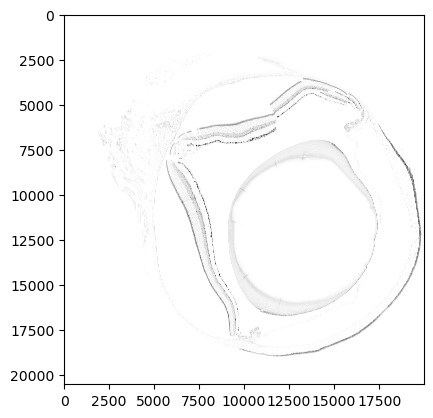

In [10]:
image_chanel_2 = tifffile.imread(fullres_chanel_2, is_ome=False, level=level)
plt.imshow(image_chanel_2, cmap='binary')
plt.axis('scaled')
plt.show()

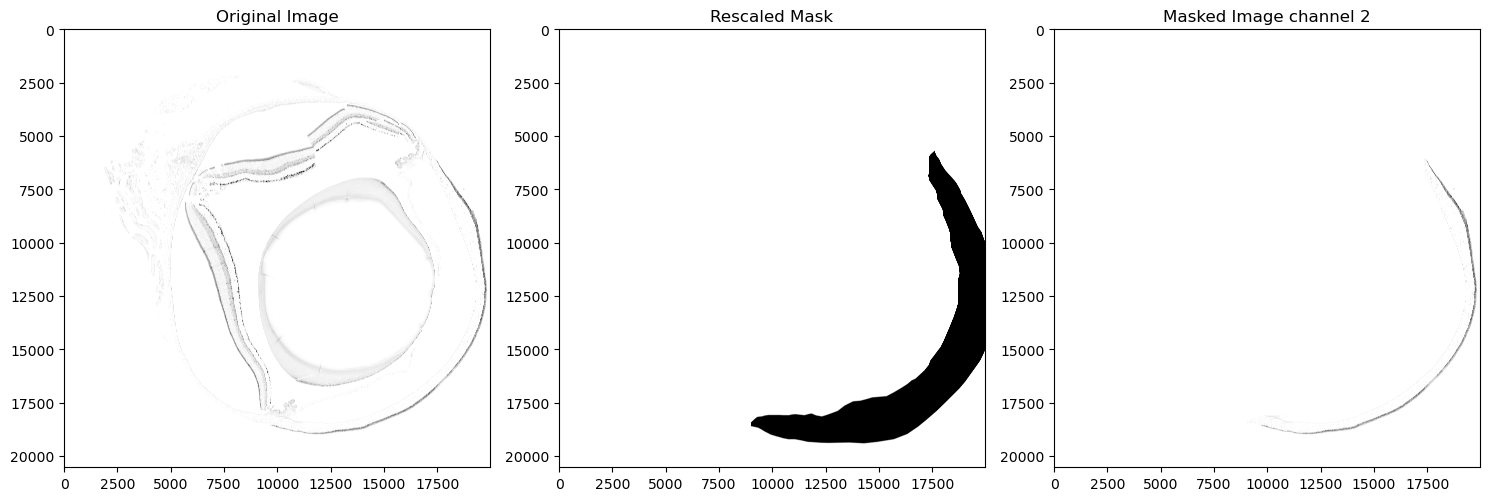

In [13]:
import cv2
import numpy as np

level = 0
pixelsize = scalefactors[level]

# 1. Rescale the coordinates
scaling_factor = pixelsize
x_coords_rescaled = x_coords / scaling_factor
y_coords_rescaled = y_coords / scaling_factor

# 2. Convert rescaled coordinates to points format for fillPoly
points_rescaled = np.column_stack((x_coords_rescaled, y_coords_rescaled)).astype(np.int32)
points_rescaled = points_rescaled.reshape((-1, 1, 2))

# 3. Create mask matching image shape
mask = np.zeros(image_chanel_0.shape, dtype=np.uint8)

# 4. Fill the polygon in white (255)
cv2.fillPoly(mask, [points_rescaled], color=255)

# 5. Apply mask to original image
mask_bool = mask > 0
masked_image_2 = np.zeros_like(image_chanel_2)
masked_image_2[mask_bool] = image_chanel_2[mask_bool]

# 6. Visualize to check the results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(image_chanel_2, cmap='binary')
plt.title('Original Image')
plt.axis('scaled')

plt.subplot(132)
plt.imshow(mask, cmap='binary')
plt.title('Rescaled Mask')
plt.axis('scaled')

plt.subplot(133)
plt.imshow(masked_image_2, cmap='binary')
plt.title('Masked Image channel 2')
plt.axis('scaled')

plt.tight_layout()
plt.show()

In [14]:

def crop_polygon_to_overlapping_squares(polygon, square_size, overlap_size=40/0.2125):
    """
    Crops a polygon into overlapping square regions of a given size.

    Args:
        polygon (Polygon): The input polygon to crop.
        square_size (float): The base size of each square region (side length).
        overlap_size (float): The amount of overlap in um (default: 20).

    Returns:
        List[Polygon]: List of overlapping square polygons that fully contain the polygon.
    """
    # Get bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds

    # Generate grid of overlapping squares
    squares = []
    for x in range(int(minx), int(maxx), square_size):
        for y in range(int(miny), int(maxy), square_size):
            # Create expanded square with overlap
            # First vertex (x, y) remains the same
            # Other vertices are expanded by overlap_size
            square = box(
                x,                          # minx (unchanged)
                y,                          # miny (unchanged)
                x + square_size + overlap_size,  # maxx (expanded)
                y + square_size + overlap_size   # maxy (expanded)
            )
            # Check if the square intersects the polygon
            if polygon.intersects(square):
                squares.append(square)
    
    return squares

In [15]:
# Combine X and Y into coordinate pairs
rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))

# Create a Polygon object
rescaled_polygon_roi = Polygon(rescaled_polygon_roi)
print(rescaled_polygon_roi)

POLYGON ((17398.729411764707 5898.44705882353, 17592.517647058823 5724, 17602.21176470588 5724, 17708.8 5966.2588235294115, 17815.38823529412 6092.235294117647, 17931.670588235294 6353.882352941177, 18115.764705882353 6634.870588235294, 18261.129411764705 6799.623529411765, 18406.49411764706 6954.682352941176, 18542.11764705882 7109.694117647059, 18629.36470588235 7225.976470588235, 18697.176470588238 7342.258823529412, 18774.682352941178 7477.929411764706, 18813.458823529414 7545.7411764705885, 18842.54117647059 7662.023529411766, 18861.929411764704 7720.1882352941175, 18910.35294117647 7797.694117647059, 19055.717647058824 8049.64705882353, 19172 8282.211764705882, 19259.2 8456.611764705882, 19365.788235294116 8679.482352941177, 19637.12941176471 9270.588235294117, 19801.83529411765 9512.84705882353, 19985.976470588237 10016.75294117647, 20111.95294117647 10443.10588235294, 20218.541176470586 10801.64705882353, 20160.376470588235 11460.564705882352, 20160.376470588235 11974.117647058

square: POLYGON ((11057.235294117647 17016, 11057.235294117647 19086.235294117647, 8987 19086.235294117647, 8987 17016, 11057.235294117647 17016))
 x: array('d', [11057.235294117647, 11057.235294117647, 8987.0, 8987.0, 11057.235294117647]) 
 y: array('d', [17016.0, 19086.235294117647, 19086.235294117647, 17016.0, 17016.0])
square: POLYGON ((11057.235294117647 18898, 11057.235294117647 20968.235294117647, 8987 20968.235294117647, 8987 18898, 11057.235294117647 18898))
 x: array('d', [11057.235294117647, 11057.235294117647, 8987.0, 8987.0, 11057.235294117647]) 
 y: array('d', [18898.0, 20968.235294117647, 20968.235294117647, 18898.0, 18898.0])
square: POLYGON ((12939.235294117647 17016, 12939.235294117647 19086.235294117647, 10869 19086.235294117647, 10869 17016, 12939.235294117647 17016))
 x: array('d', [12939.235294117647, 12939.235294117647, 10869.0, 10869.0, 12939.235294117647]) 
 y: array('d', [17016.0, 19086.235294117647, 19086.235294117647, 17016.0, 17016.0])
square: POLYGON ((129

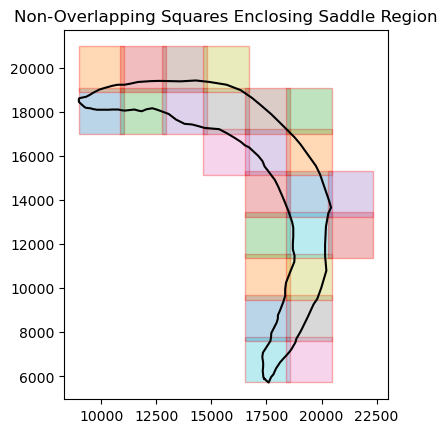

In [16]:
# Define square size
square_size = int(400/0.2125) # Adjust as necessary 


# Generate non-overlapping square regions
overlapping_squares = crop_polygon_to_overlapping_squares(rescaled_polygon_roi, square_size)

# Visualization
fig, ax = plt.subplots()
# Plot the original polygon
x, y = rescaled_polygon_roi.exterior.xy
ax.plot(x, y, 'k-', label="Saddle-shaped Polygon")  # Black for polygon

# Plot the square regions
for square in overlapping_squares:
    print("square:", square)
    x, y = square.exterior.xy
    print(" x:", x,"\n", "y:", y)
    ax.fill(x, y, edgecolor='red', alpha=0.3, label="Red Square")

# Add labels and legend
ax.set_title(f"Non-Overlapping Squares Enclosing Saddle Region")
ax.set_aspect('equal', 'box')
# ax.legend(loc="upper left")
plt.show()

In [17]:
overlapping_squares

[<POLYGON ((11057.235 17016, 11057.235 19086.235, 8987 19086.235, 8987 17016,...>,
 <POLYGON ((11057.235 18898, 11057.235 20968.235, 8987 20968.235, 8987 18898,...>,
 <POLYGON ((12939.235 17016, 12939.235 19086.235, 10869 19086.235, 10869 1701...>,
 <POLYGON ((12939.235 18898, 12939.235 20968.235, 10869 20968.235, 10869 1889...>,
 <POLYGON ((14821.235 17016, 14821.235 19086.235, 12751 19086.235, 12751 1701...>,
 <POLYGON ((14821.235 18898, 14821.235 20968.235, 12751 20968.235, 12751 1889...>,
 <POLYGON ((16703.235 15134, 16703.235 17204.235, 14633 17204.235, 14633 1513...>,
 <POLYGON ((16703.235 17016, 16703.235 19086.235, 14633 19086.235, 14633 1701...>,
 <POLYGON ((16703.235 18898, 16703.235 20968.235, 14633 20968.235, 14633 1889...>,
 <POLYGON ((18585.235 5724, 18585.235 7794.235, 16515 7794.235, 16515 5724, 1...>,
 <POLYGON ((18585.235 7606, 18585.235 9676.235, 16515 9676.235, 16515 7606, 1...>,
 <POLYGON ((18585.235 9488, 18585.235 11558.235, 16515 11558.235, 16515 9488,...>,
 <PO

In [ ]:
# TODO: file name
# Define a function to crop the image based on a shapely Polygon
def crop_region(image, poly):
    """
    Crops the rectangular bounding box of a polygon from an image.

    Parameters:
        image (ndarray): The original image to crop.
        poly (Polygon): A shapely Polygon object defining the region.

    Returns:
        ndarray: The cropped image region.
    """
    # Get the bounding box of the polygon
    min_x, min_y, max_x, max_y = map(int, poly.bounds)
    
    # Crop the image using the bounding box
    cropped_image = image[min_y:max_y, min_x:max_x]
    
    return cropped_image


# Process and plot the square regions
for i, square in enumerate(overlapping_squares):
    print(f"Processing square {i + 1}:", square)
    
    # ch 0 Crop the region 
    cropped_image_sub = crop_region(masked_image_0, square)

    # ch2 Crop the region
    cropped_image_sub2 = crop_region(masked_image_2, square)

    cropped_image_sub_combined = np.stack((cropped_image_sub, cropped_image_sub2), axis=0)


    # Save the cropped image
    save_path = f"G:/Alexis_data/Project/SpatialOmics_cellpose/results/cropped_image/cropped_square_com_{i + 1}.tif"
    tifffile.imwrite(save_path, cropped_image_sub_combined)
    print(f"Cropped image saved to {save_path}")
    

Processing square 1: POLYGON ((11057.235294117647 17016, 11057.235294117647 19086.235294117647, 8987 19086.235294117647, 8987 17016, 11057.235294117647 17016))
Cropped image saved to G:/Alexis_data/Project/SpatialOmics_cellpose/results/cropped_image/cropped_square_com_1.tif
Processing square 2: POLYGON ((11057.235294117647 18898, 11057.235294117647 20968.235294117647, 8987 20968.235294117647, 8987 18898, 11057.235294117647 18898))
Cropped image saved to G:/Alexis_data/Project/SpatialOmics_cellpose/results/cropped_image/cropped_square_com_2.tif
Processing square 3: POLYGON ((12939.235294117647 17016, 12939.235294117647 19086.235294117647, 10869 19086.235294117647, 10869 17016, 12939.235294117647 17016))
Cropped image saved to G:/Alexis_data/Project/SpatialOmics_cellpose/results/cropped_image/cropped_square_com_3.tif
Processing square 4: POLYGON ((12939.235294117647 18898, 12939.235294117647 20968.235294117647, 10869 20968.235294117647, 10869 18898, 12939.235294117647 18898))
Cropped ima

g:\Alexis_data\Project\cellpose-env\Lib\site-packages\tifffile\tifffile.py:2360: UserWarning: <tifffile.TiffWriter 'cropped_square_com_24.tif'> writing zero-size array to nonconformant TIFF
  warnings.warn(
g:\Alexis_data\Project\cellpose-env\Lib\site-packages\tifffile\tifffile.py:2360: UserWarning: <tifffile.TiffWriter 'cropped_square_com_25.tif'> writing zero-size array to nonconformant TIFF
  warnings.warn(
